In [1]:
from disk_utils_jax import jax_model, jax_model_scal
from regression import likelihood, likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
jax.config.update("jax_debug_nans", False)

2024-05-31 01:51:53.328350: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
disk_params1 = {}
disk_params1['inclination'] = 45. #In degrees
disk_params1['position_angle'] = 30. #In Degrees
disk_params1['alpha_in'] = 7. #The inner power law
disk_params1['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 30. #In degrees
disk_params2['position_angle'] = 10. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Object Jax code
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2683: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


0:00:03.317341


In [5]:
# Object Jax code
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:00.000770


Text(0.5, 1.0, 'Target Disk (Right)')

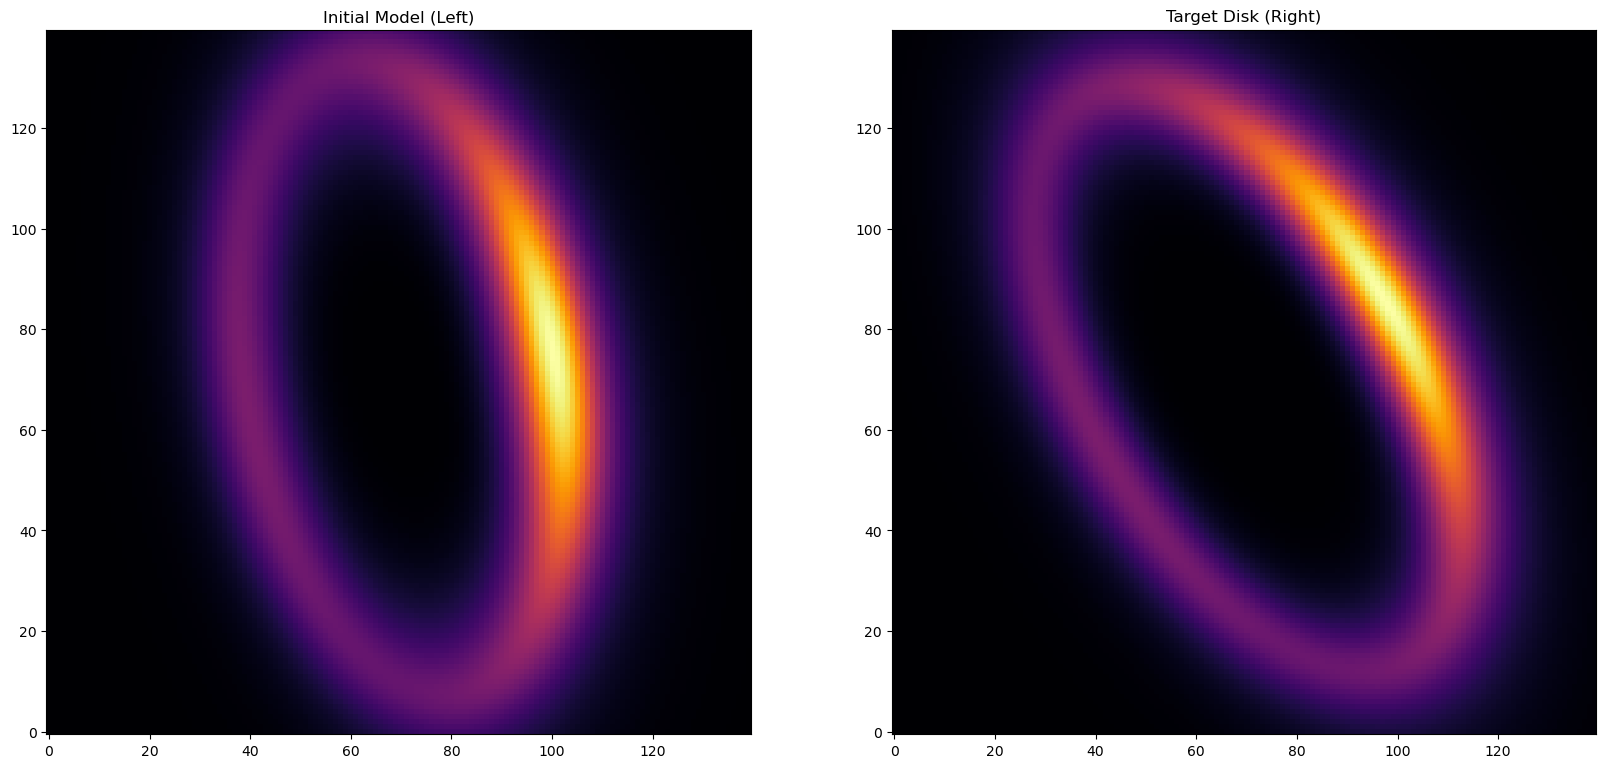

In [6]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0].set_title("Initial Model (Left)")

axes[1].imshow(disk_image1, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")

In [7]:
def test():
    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params,
              spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})

In [8]:
#%timeit test()

In [9]:
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

In [10]:
grad_func = jax.grad(jax_model_scal, argnums=(2,3))
print(grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params))

({'alpha_in': Array(0., dtype=float32, weak_type=True), 'alpha_out': Array(0., dtype=float32, weak_type=True), 'flux_scaling': Array(1., dtype=float32, weak_type=True), 'inclination': Array(0., dtype=float32, weak_type=True), 'position_angle': Array(0., dtype=float32, weak_type=True), 'sma': Array(0., dtype=float32, weak_type=True)}, {'g1': Array(0., dtype=float32, weak_type=True), 'g2': Array(0., dtype=float32, weak_type=True), 'weight': Array(0., dtype=float32, weak_type=True)})


In [11]:
import numpy as np
# 0: alpha_in, 1: alpha_out, 2: sma, 3: inclination, 4: position_angle
disk_params_1d = np.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'],
                           disk_params2['position_angle']])

In [12]:
print(likelihood_1d(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2['flux_scaling'],
                    disk_image1))

/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2683: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


-296160000000.0


In [13]:
from scipy.optimize import minimize

ll = lambda *args: -likelihood_1d(*args)

soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params2['flux_scaling'], disk_image1))
print(soln)
print(soln.x)
print(disk_params_1d)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 296160002048.0
        x: [ 5.000e+00 -7.000e+00  4.000e+01  3.000e+01  1.000e+01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 6
     njev: 1
[ 5. -7. 40. 30. 10.]
[ 5. -7. 40. 30. 10.]


In [14]:
disk_fit = {}
disk_fit['alpha_in'] = soln.x[0]
disk_fit['alpha_out'] = soln.x[1]
disk_fit['sma'] = soln.x[2]
disk_fit['inclination'] = soln.x[3]
disk_fit['position_angle'] = soln.x[4]
disk_fit['flux_scaling'] = disk_params2['flux_scaling']

In [15]:
disk_image_fit = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})

Text(0.5, 1.0, 'Target Disk')

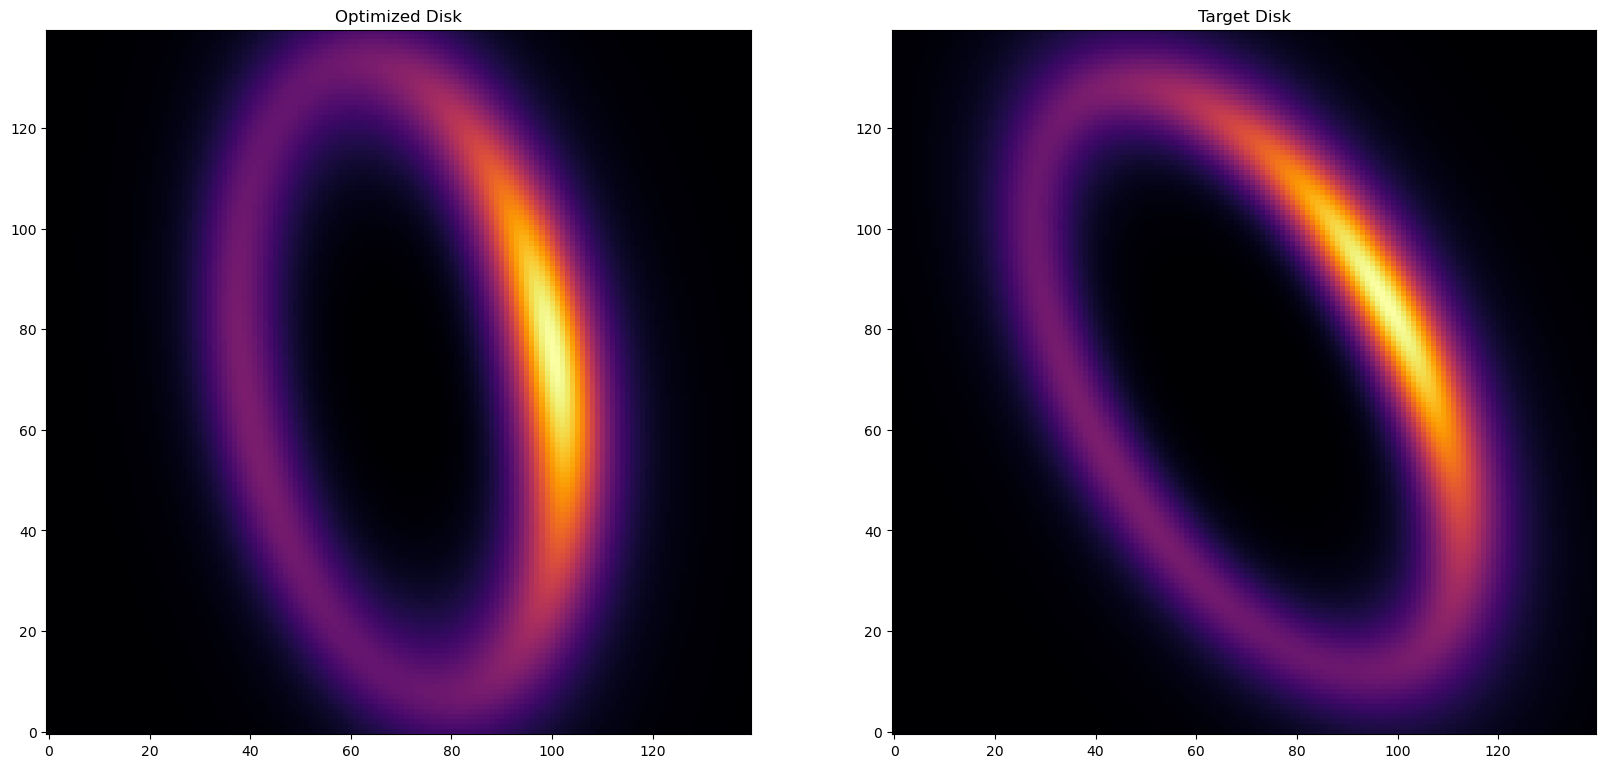

In [16]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].imshow(disk_image_fit, origin='lower', cmap='inferno')
axes[0].set_title("Optimized Disk")

axes[1].imshow(disk_image1, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")

In [17]:
from regression import manual_regression

disk_m_fit = manual_regression(disk_image1, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params)

print(disk_m_fit)
print(disk_params2)

/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2683: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


{'alpha_in': 3, 'alpha_out': -8, 'sma': 43, 'inclination': 20, 'position_angle': 19, 'flux_scaling': 1000000.0}
{'inclination': 30.0, 'position_angle': 10.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}


In [18]:
disk_image_m_fit = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_m_fit,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})

/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2683: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


Text(0.5, 1.0, 'Target Disk')

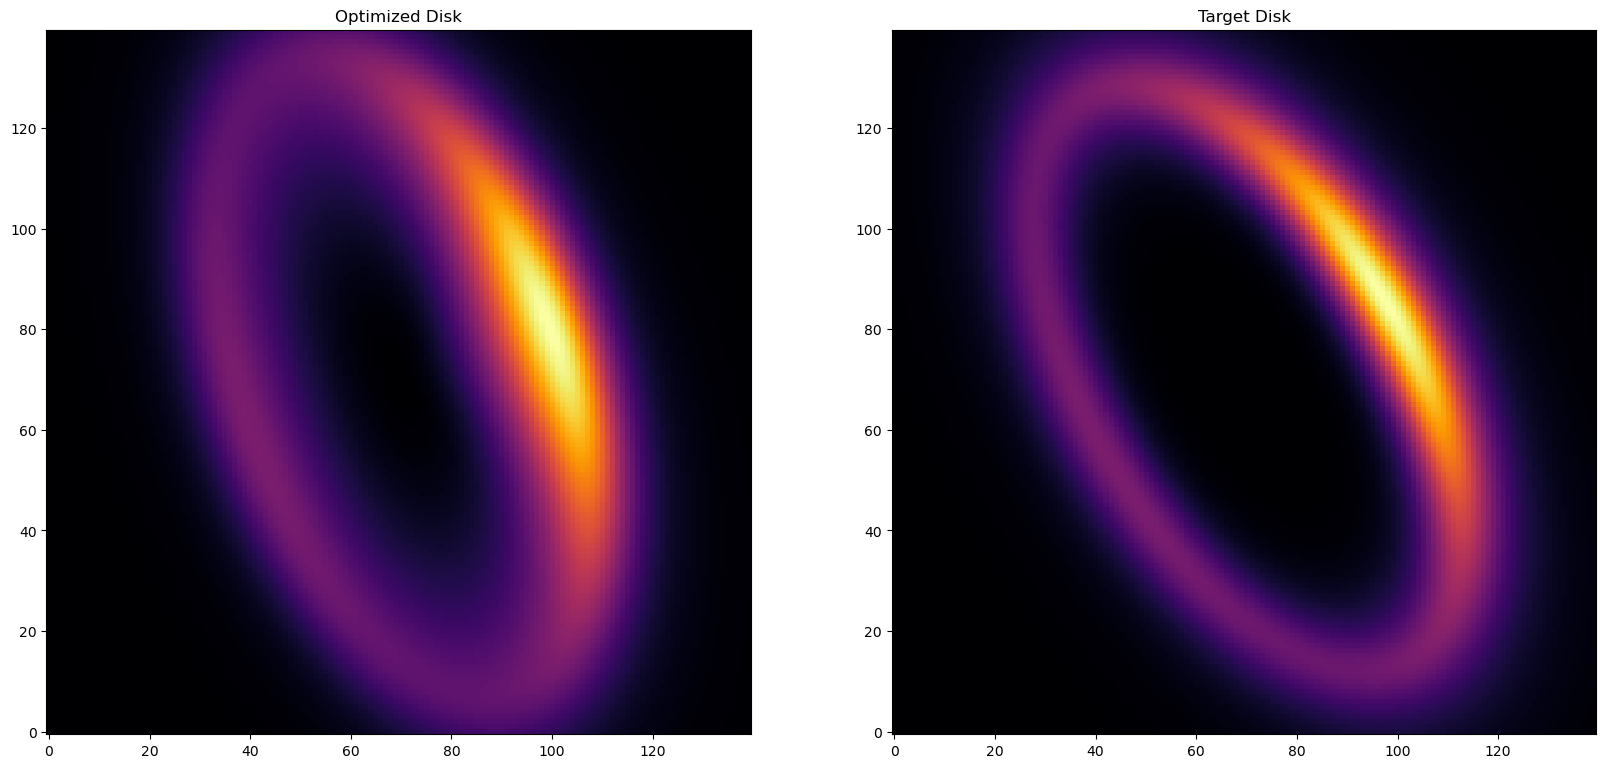

In [19]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].imshow(disk_image_m_fit, origin='lower', cmap='inferno')
axes[0].set_title("Optimized Disk")

axes[1].imshow(disk_image1, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")